# Lab 1.1: Graph Regularization

In this lab, you will learn how to perform graph-based machine learning via regularization techniques.
The specific objectives are:

*   Implement different graph-based regularization techniques to perform node-wise signal regression.
*   Analyze the trade-off between fitting and regularization.
*   Explain the perfromance of particular regularizer.

**Completion requirements**

*   Showing the graph sparsity as a function of abstract network hyper-parameters.
*   Implementing and analyzing two regularizers for signal denosing and reconstruction. 
 



## Dataset and problem definition

To achieve the above objectives, we will work with a real-world weather dataset called **Molene**.
This dataset contains weather temperature over 32 distinct stations in France recorded for a month with hourly resolution.
We will treat each time instant as a graph signal and aim to recover it from noisy measurments and signals with missing values.
For this, we will compare two regularization techniques:
*   Tikhonov regularizer
$$
\hat{\textbf{x}} = \text{arg}\min_{\textbf{x}} \|\textbf{y} - \textbf{x}\|_2^2 + \alpha \textbf{x}^T\textbf{L}\textbf{x}
$$

*   Trend filtering.
$$
\hat{\textbf{x}} = \text{arg}\min_{\textbf{x}} \|\textbf{y} - \textbf{x}\|_2^2 + \beta \|\textbf{B}^T\textbf{x}\|_1,
$$
where $\textbf{B}$ is the indcidence matrix of the graph.

## Libraries

* Numpy
* Pandas
* PyGSP or NetwrokX (or any other viable libraries)
* Scikit-learn
* Matplotlib
* CVXPy and CVXOPT (or any other optimization solver library)

In [1]:
# !pip install PyGSP
# !pip install pandas
# !pip install cvxpy

!conda install -c conda-forge PyGSP -y
!conda install -c conda-forge pandas -y
!conda install -c conda-forge cvxpy -y

Retrieving notices: ...working... ^C
failed

CondaError: KeyboardInterrupt

Retrieving notices: ...working... 

In [ ]:
!conda install -c conda-forge cvxopt -y

Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/anja/miniconda3

  added / updated specs:
    - cvxopt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cvxopt-1.3.2               |  py310ha550498_1         461 KB  conda-forge
    dsdp-5.8                   |    h6e329d1_1203         221 KB  conda-forge
    fftw-3.3.10                |nompi_h4fa670e_108         1.7 MB  conda-forge
    glpk-5.0                   |       h3cb5acd_0         1.0 MB  conda-forge
    gmp-6.3.0                  |       h73e2aa4_1         508 KB  conda-forge
    gsl-2.7                    |       h93259b0_0         3.1 MB  conda-forge
    metis-5.1.1                |       h73e2aa4_2         3.7 MB  conda-forge
    mpfr-4.2.1                 |       h4f6b447_1         365 KB  conda-forge
    suitesparse-5.10.1         |       h0a

In [1]:
import numpy as np
import pandas as pd
from pygsp import graphs, plotting
import matplotlib.pyplot as plt
import cvxpy as cp
import cvxopt as cvxopt

## Building the graph

We can treat each sensor as a node of a graph and the temperatures as signals over these nodes.
These sensors have also metadata such as their geolocation.
We can therefore build an abstract network connecting them.
This network can for instance be build using these metadata or using a portion of the time series and connecting nodes based on their statistical dependencies in them (e.g. Pearson correlation).
In either case, you could use different criteria to connect the nodes such as $k$-nearest neighbors, $\epsilon$-ball graph, etc.
*It is up to you to build any graph from any data* 

### Task 1

Build a **connected** and **sparse** graph between sensors.
Choose your hyperparameters to achieve at least 80% sparsity ($\frac{\text{zeros of } \textbf{A}}{N^2}$).
If you cannot ensure a connected graph with such a sparsity factor it can also be less sparse.
Tune your hyper parameters accordingly.

In [2]:
## Reading metadata of the stations
stations_metadata = pd.read_csv('lab1_molene/weather_stations_filtered_Molene.csv',index_col=0)
stations_metadata

,Numéro,Nom,Latitude,Longitude,Lambert II X,Lambert II Y,Altitude
0,22016001,ILE-DE-BREHAT,48°51'18N,3°00'12W,24419,2081,25
1,22092001,KERPERT,48°24'12N,3°08'48W,23925,1941,281
3,22135001,LOUARGAT,48°33'06N,3°22'36W,24101,1784,148
4,22147006,MERDRIGNAC,48°10'54N,2°24'36W,23644,2471,131
5,22168001,PLOUMANAC'H,48°49'30N,3°28'18W,24410,1735,55
6,22219003,PLOUGUENAST,48°15'54N,2°44'54W,23752,2226,235
7,22247002,POMMERIT-JAUDY,48°44'30N,3°15'00W,24306,1891,55
8,22261002,QUINTENIC,48°31'06N,2°25'12W,24018,2487,71
9,22266001,ROSTRENEN,48°13'48N,3°18'24W,23742,1809,262
10,22282001,SAINT-CAST-LE-G,48°38'36N,2°14'48W,24149,2622,35


In [7]:
## extracting the coordinates for each station from the metadata => these coordinates can be treated as distance
coordinates_df = stations_metadata.iloc[:,-3:]  
coordinates_df = coordinates_df - coordinates_df.mean() # => Removing mean to have more tangible coordinates
coordinates = coordinates_df.to_numpy()


In [ ]:
!conda install -c conda-forge scikit-learn -y

Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/anja/miniconda3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.4.2               |     pyhd8ed1ab_0         215 KB  conda-forge
    scikit-learn-1.4.2         |  py310h38ce860_0         7.8 MB  conda-forge
    threadpoolctl-3.5.0        |     pyhc1e730c_0          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.0 MB

The following NEW packages will be INSTALLED:

  joblib             conda-forge/noarch::joblib-1.4.2-pyhd8ed1ab_0 
  scikit-learn       conda-forge/osx-64::scikit-learn-1.4.2-py310h38ce860_0 
  threadpoolctl      conda-forge/noarch::threadpoolctl-3.5.0-pyhc1e730c_0 



scikit-learn-1.4.2   | 7.8

In [8]:

## You can PyGSP or NetwrokX pakcage for this to have predefined graph builders.

# Build a graph using NetworkX package that places nodes based on their coordinates
import networkx as nx
import sklearn
from sklearn.neighbors import kneighbors_graph


def check_sparsity(G):
    A = nx.adjacency_matrix(G).todense()
    sparsity = np.sum(A>0)/(len(coordinates)**2)
    

    # If the graph sparsity is NOT less than 80%, print an error statement in red
    if sparsity > 0.2:
        print('\033[91m' + 'The graph is not sparse enough. Please try again with different hyperparameters.')
        return 1
    
    # if the graph is not connected, then return a 0
    if nx.is_connected(G) == False:
        print('\033[91m' + 'The graph is not connected. Please try again with different hyperparameters.')
        return 0

    print('\033[30m' + 'The sparsity of the graph is: ' + str(sparsity))

    return sparsity

### CHECK THIS PART -- Do I need to implement the sim(i,j) function specifically?
def create_graph(coordinates, k):
    print('\033[30m' + 'For k: ' + str(k))
    G = nx.Graph()
    for i in range(len(coordinates)):
        G.add_node(i, pos=(coordinates[i,0], coordinates[i,1]))
    A = kneighbors_graph(coordinates, n_neighbors=k).toarray()
    for i in range(len(coordinates)):
        for j in range(i+1, len(coordinates)):
            if A[i,j] == 1:
                G.add_edge(i, j)
    return G

def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, node_size=100)
    plt.show()

G = create_graph(coordinates, 3)
sp = check_sparsity(G)
# plot_graph(G)

For k: 3
The sparsity of the graph is: 0.095703125


### Question 1
What type of graph did you use and what is the hyperparameter of it?
Make a plot of the graph sparsity as a function of at least one hyper parameter.
Make sure the graph remains connected.

**Answer**:
<font color = 'red'>
I used the kNN algorithm to build the graph. The hyperparameter of choice is k, the amount of neighbors to connect each node to. 

For k: 1
The graph is not connected. Please try again with different hyperparameters.
For k: 2
The graph is not connected. Please try again with different hyperparameters.
For k: 3
The sparsity of the graph is: 0.095703125
For k: 4
The sparsity of the graph is: 0.126953125
For k: 5
The sparsity of the graph is: 0.16015625
For k: 6
The sparsity of the graph is: 0.19140625
For k: 7
The graph is not sparse enough. Please try again with different hyperparameters.


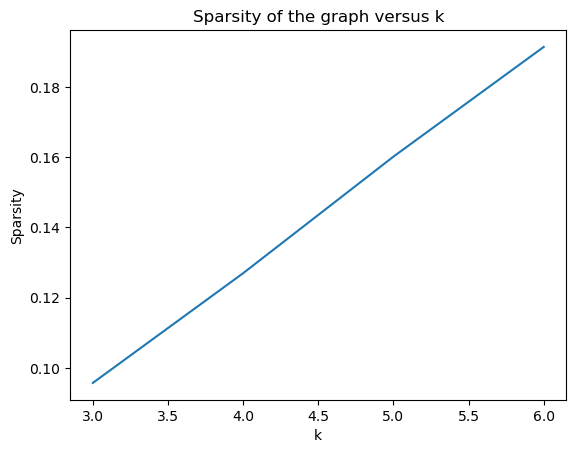

In [9]:
## Plot of Graph sparisty versus value for k (number of neighbors)
sparsity_values = []
k_values = [1,2,3,4,5,6,7,8,9,10]

for k in k_values:
    G = create_graph(coordinates, k)
    sp_G = check_sparsity(G)
    if (sp_G == 1):
        break
    sparsity_values.append(sp_G)

# figure out how many sparsity values are 0
num_zeros = sparsity_values.count(0)

plt.plot(k_values[(num_zeros):len(sparsity_values)], sparsity_values[(num_zeros):])
plt.xlabel('k')
plt.ylabel('Sparsity')
plt.title('Sparsity of the graph versus k')
plt.show()



## Noisy measurements

Let $e$ be the average energy of the graph signals in the dataset.
$$
e = \frac{1}{m} \sum_{i=1}^m \|\textbf{x}_i\|_2^2,
$$
where $m$ is the number of data points.
Generate $m$ noisy graph signal $\textbf{y} = \textbf{x} + \textbf{n}$ where $\textbf{n}$ is a zero-mean Gaussian noise $\textbf{n} \sim \mathcal{N}(0,σ^2\textbf{I})$.
Consider $\sigma^2 = e/2$.

In [10]:
## loading the data
timeseries_data = pd.read_csv('lab1_molene/filtered_data_Molene.csv', index_col = 'date', parse_dates = True)
timeseries_data = timeseries_data - timeseries_data.mean() # => removing mean from data

In [11]:
x = timeseries_data.to_numpy().transpose()  # => transpose the data so we have each column as a graph signal

e = np.sum(np.square(x))/x.shape[1] # computing average energy

sigma = e/x.shape[0]/2
n = np.random.multivariate_normal(np.zeros(x.shape[0]),sigma*np.eye(x.shape[0]),size=x.shape[1]).transpose() # => generating noise

y = x + n   # adding to noise to synthesize noisy observations
print(y.shape)

(32, 744)


## Missing measurements

Consider now that the signal is noiseless but it is observed only in a portion of the nodes: $\textbf{y} = \textbf{P} \textbf{x}$, where $\textbf{P} \in \mathbb{R}^{N \times N}$ is the sampling matrix collecting $M$ out of the possible $N$ samples. 

### Task 2

Fix a non-zero regularization weight and show the rNMSE of the recovered signal for both regularizers and $M = \{3,9,15,21,27\}$.

In [12]:
## add your code here
## Generate the data with missing values (or only indices).

M = [3,9,15,21,27]

collection_Ms = []
for m in M:
    # Matrix M is filled which zeros and 1s. It is of dimension M x N. An element is 1 if the node is observed and 0 else. m elements are 1 in each column.
    M = np.zeros((x.shape[0], x.shape[0]))
    rand_inx_i = np.random.choice(x.shape[0], m , replace=False)        # enforcing that always different row selected
    rand_inx_j = np.random.choice(x.shape[0], m , replace=True)
    for i in range(m):
        M[rand_inx_i[i], rand_inx_j[i]] = 1
    num_ones = np.count_nonzero(M)
    assert num_ones == m, "Number of 1s in the matrix is not equal to m"
    collection_Ms.append(M)


In [13]:
## Add your code here
## solve and evaluate for Tikhonov regularizer

def tikhonov(y_in, M, G, gamma):
    all_x_opt = np.zeros((y_in.shape[0], y_in.shape[1]))
    # print(all_x_opt.shape)
    for i in range(y_in.shape[1]):     # for every column in y (number of time steps)
        x_opt = np.linalg.inv(M.T @ M + gamma * nx.laplacian_matrix(G).todense()) @ M.T @ M @ y_in[:, i] # correct 32 x 1
        # it is dimension (32,) make it dimension 32,1
        x_opt = x_opt.reshape(-1, 1)
        # print(x_opt.shape)
        all_x_opt[:,i] = x_opt[:,0]
    return all_x_opt

def nmse(x, x_opt):
    nmse = np.sum(np.square(x-x_opt))/np.sum(np.square(x))
    print("NMSE: ", nmse)
    return nmse

# Testing with the first M matrix
y_here = collection_Ms[1] @ x          # sample only select nodes in y
x_optimal = tikhonov(y_here, collection_Ms[1], G, gamma=1)
x_optimal = np.array(x_optimal)
error = nmse(x, x_optimal)

for i in range(len(collection_Ms)):
    y = collection_Ms[i] @ x
    x_optimal = tikhonov(y, collection_Ms[i], G, gamma=1)
    print("For m = ", np.count_nonzero(collection_Ms[i]))
    x_optimal = np.array(x_optimal)
    # print(x_optimal[:, 5])
    error = nmse(x, x_optimal)



NMSE:  0.3903316222004381
For m =  3
NMSE:  1.0
For m =  9
NMSE:  0.3903316222004381
For m =  15
NMSE:  0.40298858161308393
For m =  21
NMSE:  0.28861333704613973
For m =  27
NMSE:  0.20165215865322603


In [14]:
## Add your code here
## solve and evaluate for the regularizer of your choice - TREND FILTERING

# SOLVE WITH TREND FILTERING
# minimize ||y-x||_2^2 + beta*||L*x||_1 and solve 
def trend_filtering(y_in, G, gamma):
    all_x_opt = np.zeros((y_in.shape[0], y_in.shape[1]))
    
    for i in range(y_in.shape[1]):                 # for every column in x (number of time steps)
        x_opt = cp.Variable(y_in.shape[0])
        objective = cp.Minimize(cp.norm2(y_in[:,i]-x_opt) + gamma*cp.norm1(nx.laplacian_matrix(G).todense() @ x_opt))
        prob = cp.Problem(objective)
        result = prob.solve()
        x_opt = x_opt.value
        x_opt = x_opt.reshape(-1, 1)
        all_x_opt[:,i] = x_opt[:,0]
        
    return all_x_opt

def nmse(x, x_opt):
    nmse = np.sum(np.square(x-x_opt))/np.sum(np.square(x))
    print("NMSE: ", nmse)
    return nmse

y_here = collection_Ms[0] @ x          # sample only select nodes in y
x_optimal = trend_filtering(y_here, G, gamma=0.1)
x_optimal = np.array(x_optimal)
error = nmse(x, x_optimal)


for i in range(len(collection_Ms)):
    y_here = collection_Ms[i] @ x
    x_optimal = trend_filtering(y_here, G, gamma=1)
    print("For m = ", np.count_nonzero(collection_Ms[i]))
    x_optimal = np.array(x_optimal)
    # print(x_optimal[:, 10])
    error = nmse(x, x_optimal)


NMSE:  0.8685296381544715
For m =  3
NMSE:  0.8604676012239942
For m =  9
NMSE:  0.565796010029231
For m =  15
NMSE:  0.38049615742520415
For m =  21
NMSE:  0.26648272808304113
For m =  27
NMSE:  0.2012852403519994


### Question 2
 What would you conclude about the behaviour of the two regularizers?

**Answer**:
<font color = 'red'>
As the number of missing samples decreases, the error decreases which is in line with expectations for both regularizers. The trend filtering regularizer works slightly better but this result may be dependent upon the value for gamma chosen. With tuning of gamma, it is likely that a lower NMSE could be obtained for tikhonov regularization, for example. 

# Optional Exercises

### The following exercises are __optional__, meaning they do not count toward the completion of this assignment. Only do them if you would like to learn more and if you have the time.

### Task 3

Use the Tikhonov regularizer for a choice of $\alpha > 0$ to recover signal $\textbf{x}$ from the measurements $\textbf{y}$.
Provide the signal recovery metric root normalized mean square error (rNMSE)
$$
\text{rNMSE} = \left(\frac{\sum_{i=1}^m \|\hat{\textbf{x}}_i-\textbf{x}_i\|_2^2}{\sum_{i=1}^m\|\textbf{y}_i\|_2^2}
\right)^{0.5}
$$

In [ ]:
## set the regularizer coefficient
alpha = ... 

## exploit the graph Laplacian (if you are using pygsp, convert it to dense format from sparse for further computations(use .todense()).
L = ...

## write down the closed form solution for Tikhonov regularizer
x_hat = np.matmul(np.linalg.inv(...),y) 

rnmse = np.sqrt(np.square(x_hat-x).mean())/y.std()  # rnmse definition

print(f"The rNMSE is: {np.round(rnmse,4)}")


### Question 3

Illustrate rNMSE as a function of $\alpha \in [0,10]$. What do you conclude about the role of the regularizer?




In [ ]:
## Add your code here

**Answer**:
<font color = 'red'>
Write your answer here ...

### Question 4

Consider now different noisy scenarios, $\sigma^2 = e/10$ and $\sigma^2 = e$.
Add the respective line into your plot.
What do you conclude about the role of the regularizer?

In [ ]:
## Add your code here

**Answer**:
<font color = 'red'>
Write your answer here ...

### Task 4

Implement trend filtering regularizer and compare the performance with the Tikhonov regularizer for $\sigma^2 = e/2$.

<font color = 'red'>
Write the regularizer of your choice here


In [ ]:
## Add your code here.
## You may need an optimization solver if your chosen regularizer does not have a closed form solution.

### Question 5

Why and when does one regularizer performs better than the other?

**Answer**:
<font color = 'red'>
Write your answer here ...